In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
%matplotlib inline
import os
import math
import scipy.integrate as integrate
import time

In [52]:
# filename = '/home/xams/xams/PMT12_gain/K_series/K0800.hdf5'
dirname = '/home/xams/lena/run8/processed/pmtdata/'
runname = '170313_101418'
if not os.path.exists(dirname + runname + '.hdf5'):
    raise FileNotFoundError("not found")
    
store = pd.HDFStore(dirname + runname + '.hdf5')
data= store['all_hits']
datapmt1 = data[data['channel'] == 3]
datapmt2 = data[data['channel'] == 0]
heights1 = datapmt1['height']*1.602e-19/2e-9*50*1000
heights2 = datapmt2['height']*1.602e-19/2e-9*50*1000

print(len(datapmt1))

1009140


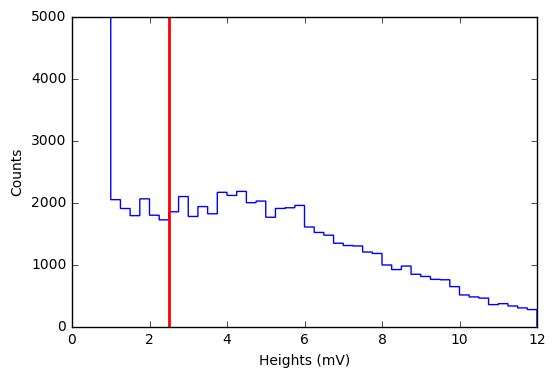

In [56]:
histboundaries = [0,12]
histbinwidth = 0.25
fitstart = 2.5
ymax = 5000
histbins = np.arange(histboundaries[0], histboundaries[1]+histbinwidth/2.0, histbinwidth)
centers = np.arange(histboundaries[0]+histbinwidth/2.0, histboundaries[1], histbinwidth)
centerscut = [c for c in centers if c>=fitstart]

pmt = 2

if pmt==1:
    hist = plt.hist(heights1, bins=histbins, histtype='step', color = 'blue')
if pmt==2:
    hist = plt.hist(heights2, bins=histbins, histtype='step', color = 'blue')

counts = hist[0]
countscut = counts[-len(centerscut):]
countserr= [np.sqrt(t)+0.5 for t in counts]
countserrcut  = countserr[-len(centerscut):]
# plt.plot(centerscut, countscut, color = 'red')

plt.xlabel("Heights (mV)")
plt.ylabel("Counts")
plt.axvline(x = fitstart, linewidth = 2, color = 'red')
# plt.yscale('log')
plt.ylim(0,ymax)
plt.show()


[ 1999.73670378     3.69407686     3.99344533]


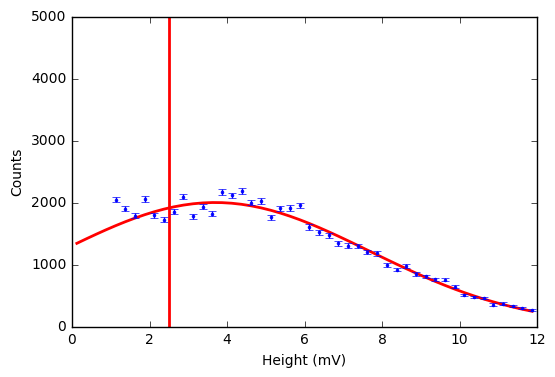

In [57]:
def gauss(x, a1, b1, s1):
    return a1 * np.exp(-(x-b1)**2/(2*s1**2))

def xgauss(x, a1, b1, s1):
    return a1 * x * np.exp(-(x-b1)**2/(2*s1**2))

ag = 80
bg = 17
sg = 4

popt, pcov = curve_fit(gauss, centerscut, countscut, sigma = countserrcut, p0=[ag, bg, sg])
perr = np.sqrt(np.diag(pcov))
af, bf, sf = popt

print(popt)

fitcounts = [gauss(t, popt[0], popt[1], popt[2]) for t in centers]
gescounts = [gauss(t, ag, bg, sg) for t in centers]


plt.plot(centers, fitcounts, color='red', linewidth = 2)
plt.errorbar(centers, counts, yerr = countserr, fmt = '.', markersize = 4)

# plt.plot(centers, gescounts, color='black', linewidth = 1)
plt.xlabel("Height (mV)")
plt.ylabel("Counts")
plt.axvline(x = fitstart, linewidth = 2, color = 'red')
# plt.yscale('log')
plt.xlim()
plt.ylim(0,ymax)

plt.show()

In [50]:
def signal_acceptance(x):
    totalsignal = integrate.quad(gauss, 0, np.inf, args = (af, bf, sf))[0]
    cutsignal = integrate.quad(gauss, x, np.inf, args = (af, bf, sf))[0]
    return cutsignal/totalsignal

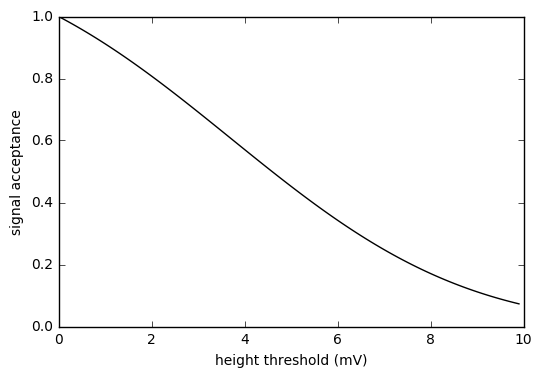

In [58]:
xrange = np.arange(0,10,0.1)
sa = [signal_acceptance(x) for x in xrange]

plt.plot(xrange, sa, color = 'black')
plt.xlabel('height threshold (mV)')
plt.ylabel('signal acceptance')
# plt.ylim(0,1)
# plt.xlim(0,2)
plt.savefig('signal_accept.pdf', format='pdf')
plt.show()